# Aula 09 - CARS - Exercícios

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

### Importar base de dados

In [22]:
import wget
from pathlib import Path

ml_url = "https://files.grouplens.org/datasets/movielens/ml-100k.zip"
zip_path = Path("ml-100k.zip")
if not zip_path.exists():
    wget.download(ml_url, out=str(zip_path))
else:
    print("Arquivo já existe, reutilizando download anterior.")
!unzip -o ml-100k.zip > /dev/null

Arquivo já existe, reutilizando download anterior.


In [23]:
rating = pd.read_csv('./ml-100k/u.data', sep='\t', names=['userId', 'itemId', 'rating', 'timestamp'])
rating.drop('timestamp', axis=1, inplace=True)
rating.head()

,userId,itemId,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [24]:
#Load the Movies data
item = pd.read_csv('./ml-100k/u.item', sep="|", encoding='latin-1', header=None)
item.columns = ['itemId', 'title' ,'release','video release date', 'IMDb URL', 'unknown', 'Action', 
                'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
                'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
item.drop(columns=['release', 'video release date', 'IMDb URL'], inplace=True)

item = item.melt(id_vars=['itemId', 'title'], var_name='genre')
item = item[item.value == 1]
item.drop(columns=['value'], inplace=True)
item[item['itemId']==1]

item.head()

,itemId,title,genre
266,267,unknown,unknown
1372,1373,Good Morning (1971),unknown
1683,2,GoldenEye (1995),Action
1685,4,Get Shorty (1995),Action
1698,17,From Dusk Till Dawn (1996),Action


In [25]:
#Load the User data
user = pd.read_csv('./ml-100k/u.user', sep='|', encoding='latin-1', header=None)
user.columns = ['userId', 'age', 'gender', 'occupation', 'zipcode']
user.head()

,userId,age,gender,occupation,zipcode
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


### Obs. Para o exercício abaixo, você poderá resolvê-lo usando a implementação própria contida neste notebook, ou então usar a biblioteca fastFM, cujo exemplo de uso está no notebook Aula09_Exemplos_fastFM.ipynb

***Exercício 01:*** Na aula, vimos a implementação e a aplicação do Factorization Machines (FM) com dois tipos de contexto: gêneros dos filmes e profissão do usuário. Verifique o desempenho do RMSE quando mais informações de contexto são incorporadas:
- Década de lançamento do filme: classifique os filmes por década: 60's, 70's, 80's, 90's, etc. 
- Sexo do usuário: M ou F. 
- Faixa etária: classifique os usuários por faixa etária, por exemplo: criança (até 12 anos), adolescente (13 a 17 anos), adulto (18 a 50 anos) e idoso (acima de 51 anos). 
- CEP: utilizar a biblioteca https://www.pythonpool.com/uszipcode-python/ de acordo com o exemplo abaixo

### Obter informações do usuário a partir do CEP (https://www.pythonpool.com/uszipcode-python/)

In [37]:
!pip install --quiet pgeocode Cython
!pip install --quiet fastFM

### Consultando o estado

In [39]:
import pgeocode
import re

nomi = pgeocode.Nominatim('us')
user['zip_short'] = user['zipcode'].astype(str).str[:5]

def lookup_state(zipcode):
    if not isinstance(zipcode, str) or zipcode.strip() == '' or zipcode.strip().lower() == 'nan':
        return 'unknown'
    info = nomi.query_postal_code(zipcode)
    state_code = getattr(info, 'state_code', None) if info is not None else None
    return state_code if isinstance(state_code, str) and state_code.strip() else 'unknown'

user['state'] = user['zip_short'].apply(lookup_state)
user['state'] = user['state'].fillna('unknown')

def categorize_age(age):
    if pd.isna(age):
        return 'unknown'
    age = int(age)
    if age <= 12:
        return 'child'
    if age <= 17:
        return 'teen'
    if age <= 50:
        return 'adult'
    return 'senior'

user['age_group'] = user['age'].apply(categorize_age)

movie_cols = ['itemId', 'title', 'release_date', 'video_release_date', 'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies_full = pd.read_csv('./ml-100k/u.item', sep='|', names=movie_cols, encoding='latin-1')
genre_columns = [col for col in movie_cols if col not in ['itemId', 'title', 'release_date', 'video_release_date', 'IMDb_URL']]

def extract_year(title):
    match = re.search(r'\((\d{4})\)', str(title))
    return int(match.group(1)) if match else np.nan

def map_decade(year):
    if pd.isna(year):
        return 'Unknown'
    decade_start = int(year // 10 * 10)
    return f"{decade_start}s"

movies_full['year'] = movies_full['title'].apply(extract_year)
movies_full['decade'] = movies_full['year'].apply(map_decade)

def collect_genres(row):
    genres = [genre for genre in genre_columns if row.get(genre, 0) == 1]
    return genres if genres else ['unknown']

movies_full['genres'] = movies_full[genre_columns].apply(collect_genres, axis=1)

movie_features = movies_full[['itemId', 'title', 'decade', 'genres']].copy()

rating_context = rating.merge(
    user[['userId', 'gender', 'occupation', 'age_group', 'state']],
    on='userId',
    how='left'
 ).merge(
    movie_features,
    on='itemId',
    how='left'
 )
rating_context['decade'] = rating_context['decade'].fillna('Unknown')
rating_context['genres'] = rating_context['genres'].apply(lambda g: g if isinstance(g, list) else ['unknown'])

rating_context.head()

,userId,itemId,rating,gender,occupation,age_group,state,title,decade,genres
0,196,242,3,M,writer,adult,MN,Kolya (1996),1990s,[Comedy]
1,186,302,3,F,executive,adult,unknown,L.A. Confidential (1997),1990s,"[Crime, Film-Noir, Mystery, Thriller]"
2,22,377,1,M,writer,adult,KY,Heavyweights (1994),1990s,"[Children's, Comedy]"
3,244,51,2,M,technician,adult,CO,Legends of the Fall (1994),1990s,"[Drama, Romance, War, Western]"
4,166,346,1,M,educator,adult,MN,Jackie Brown (1997),1990s,"[Crime, Drama]"


/home/coqzieiro/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/coqzieiro/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/coqzieiro/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/coqzieiro/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate t

,config,rmse
3,+ Década e Estado,1.370426
2,+ Sexo e Faixa Etária,1.386323
1,+ Gêneros,1.422953
0,Usuário + Item,1.444633


/tmp/ipykernel_51393/2491554528.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='config', y='rmse', palette='viridis')


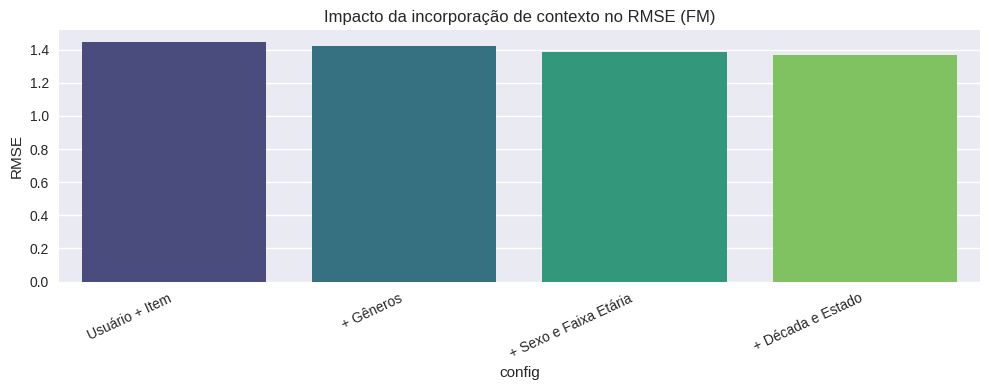

In [40]:
import sys
import subprocess
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error

try:
    from fastFM import als
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "fastFM", "--quiet"])
    from fastFM import als

plt.style.use('seaborn-v0_8')

def build_feature_dicts(df, config):
    feature_dicts = []
    for row in df.itertuples():
        features = {
            'user': f"user_{row.userId}",
            'item': f"item_{row.itemId}",
        }
        if config.get('include_genre', False):
            for genre in row.genres:
                features[f"genre={genre}"] = 1
        if config.get('include_gender', False):
            features[f"gender={row.gender}"] = 1
        if config.get('include_age', False):
            features[f"age_group={row.age_group}"] = 1
        if config.get('include_decade', False):
            features[f"decade={row.decade}"] = 1
        if config.get('include_state', False):
            features[f"state={row.state}"] = 1
        feature_dicts.append(features)
    return feature_dicts

def evaluate_config(name, config):
    feature_dicts = build_feature_dicts(rating_context, config)
    dv = DictVectorizer()
    X = dv.fit_transform(feature_dicts)
    y = rating_context['rating'].astype(float).values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    fm = als.FMRegression(rank=16, l2_reg_w=0.1, l2_reg_V=0.1, n_iter=60)
    fm.fit(X_train, y_train)
    y_pred = fm.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return {'config': name, 'rmse': rmse}

experiment_configs = [
    ('Usuário + Item', {}),
    ('+ Gêneros', {'include_genre': True}),
    ('+ Sexo e Faixa Etária', {'include_genre': True, 'include_gender': True, 'include_age': True}),
    ('+ Década e Estado', {'include_genre': True, 'include_gender': True, 'include_age': True, 'include_decade': True, 'include_state': True}),
]

results = []
for name, config in experiment_configs:
    results.append(evaluate_config(name, config))

results_df = pd.DataFrame(results)
display(results_df.sort_values('rmse'))

plt.figure(figsize=(10, 4))
sns.barplot(data=results_df, x='config', y='rmse', palette='viridis')
plt.xticks(rotation=25, ha='right')
plt.ylabel('RMSE')
plt.title('Impacto da incorporação de contexto no RMSE (FM)')
plt.tight_layout()
plt.show()